# Vine copula sampling order

> how many h-function calls will be incurred during sampling from a vine, in worst case (D-vine), using worst/best sample order?


In [1]:
import sys
import platform
import pandas as pd
import torch
import torchvinecopulib as tvc

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
# DEVICE = "cpu"
print("Python:", sys.version.replace("\n", " "))
print("Platform:", platform.platform())
print("PyTorch:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
torch.random.manual_seed(42)
is_cop_scale = True
num_dim = 6
obs = torch.rand(size=(100, num_dim), dtype=torch.float64)

Python: 3.13.2 (main, Mar 17 2025, 21:02:54) [Clang 20.1.0 ]
Platform: Linux-5.15.167.4-microsoft-standard-WSL2-x86_64-with-glibc2.35
PyTorch: 2.7.0+cu126
CUDA available: True


VineCop
'num_dim': 6,
 'num_obs': 100,
 'is_cop_scale': True,
 'mtd_bidep': 'chatterjee_xi',
 'negloglik': 0.0,
 'num_step_grid': 128,
 'dtype': torch.float64,
 'device': device(type='cpu'),
 'sample_order': (4, 5, 1, 2, 0, 3),
 'matrix':
    tensor([[ 4,  5,  1,  3,  0,  2],
            [-1,  5,  2,  0,  3,  1],
            [-1, -1,  1,  2,  0,  3],
            [-1, -1, -1,  2,  3,  0],
            [-1, -1, -1, -1,  0,  3],
            [-1, -1, -1, -1, -1,  3]], dtype=torch.int32)




(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Vine level 0'}>,
 <networkx.classes.graph.Graph at 0x7fa3b9fe5d30>)

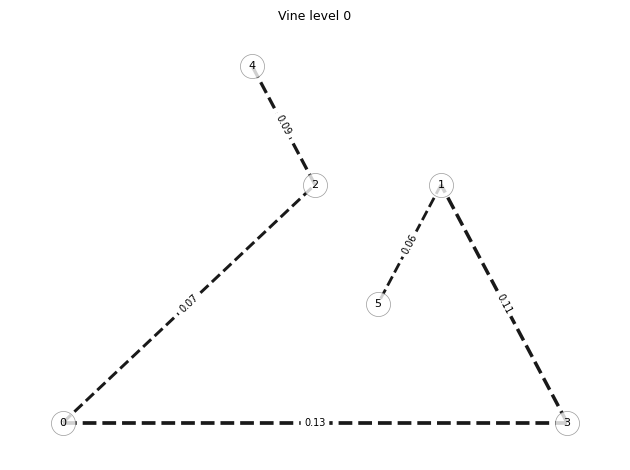

In [2]:
mdl_vcp = tvc.VineCop(
    num_dim=obs.shape[1],
    # ! indicates whether the data is in the copula scale !
    is_cop_scale=is_cop_scale,
)
mdl_vcp.fit(
    obs=obs,
    mtd_vine="dvine",
    thresh_trunc=-1,
)
print(mdl_vcp)
mdl_vcp.draw_lv()

In [3]:
def worst_sample_order(mdl_vcp):
    last_tree_vertex = set(range(mdl_vcp.num_dim)) - set(mdl_vcp.first_tree_vertex)
    sample_order = []
    for v_s_parent in mdl_vcp.struct_obs[::-1]:
        cost_best = -float("inf")
        cand_v = set()
        for v_s, cond_ed in v_s_parent.items():
            if cond_ed:
                # * not yet top lv
                v_l, v_r = map(int, cond_ed.split(","))
                if v_l not in sample_order and v_r not in sample_order:
                    cand_v.add(v_l)
                    cand_v.add(v_r)
            elif v_s[0] not in sample_order:
                # * top lv, only one choice
                cand_v.add(v_s[0])
        # ! prioritize those not in first_tree_vertex
        cand_v_last = cand_v & last_tree_vertex
        if cand_v_last:
            cand_v = cand_v_last
        for v in sorted(cand_v):
            _, _, cost = mdl_vcp.ref_count_hfunc(
                num_dim=mdl_vcp.num_dim,
                struct_obs=mdl_vcp.struct_obs,
                sample_order=sample_order + [v],
            )
            if cost > cost_best:
                cost_best = cost
                v_best = v
        sample_order.append(v_best)
    return sample_order


sample_order = worst_sample_order(mdl_vcp)

print(
    f"sample order: {sample_order}, cost: {
        mdl_vcp.ref_count_hfunc(
            num_dim=mdl_vcp.num_dim,
            struct_obs=mdl_vcp.struct_obs,
            sample_order=sample_order,
        )[2]
    }"
)
print(
    f"sample order: {mdl_vcp.sample_order}, cost: {
        mdl_vcp.ref_count_hfunc(
            num_dim=mdl_vcp.num_dim,
            struct_obs=mdl_vcp.struct_obs,
            sample_order=mdl_vcp.sample_order,
        )[2]
    }"
)

sample order: [4, 2, 0, 3, 1, 5], cost: 11
sample order: (4, 5, 1, 2, 0, 3), cost: 7


# range dim


In [ ]:
lst_num_dim = []
lst_num_hfunc_best_dvine = []
lst_num_hfunc_worst_dvine = []
lst_num_hfunc_best_dvine_cond = []
lst_num_hfunc_worst_dvine_cond = []
lst_num_hfunc_best_cvine = []
lst_num_hfunc_worst_cvine = []
lst_num_hfunc_best_cvine_cond = []
lst_num_hfunc_worst_cvine_cond = []
for num_dim in list(range(3, 50, 3)):
    lst_num_dim.append(num_dim)
    mdl_vcp = tvc.VineCop(num_dim=num_dim, is_cop_scale=is_cop_scale)
    # ! thresh_trunc=-1, no fitting
    # * dvine
    mdl_vcp.fit(obs=torch.rand(size=(10, num_dim)), mtd_vine="dvine", thresh_trunc=-1)
    sample_order = worst_sample_order(mdl_vcp)
    lst_num_hfunc_best_dvine.append(
        mdl_vcp.ref_count_hfunc(
            num_dim=mdl_vcp.num_dim,
            struct_obs=mdl_vcp.struct_obs,
            sample_order=mdl_vcp.sample_order,
        )[2]
    )
    lst_num_hfunc_worst_dvine.append(
        mdl_vcp.ref_count_hfunc(
            num_dim=mdl_vcp.num_dim,
            struct_obs=mdl_vcp.struct_obs,
            sample_order=sample_order,
        )[2]
    )
    # * dvine conditional sampling
    lst_num_hfunc_best_dvine_cond.append(
        mdl_vcp.ref_count_hfunc(
            num_dim=mdl_vcp.num_dim,
            struct_obs=mdl_vcp.struct_obs,
            sample_order=mdl_vcp.sample_order[: num_dim // 2],
        )[2]
    )
    lst_num_hfunc_worst_dvine_cond.append(
        mdl_vcp.ref_count_hfunc(
            num_dim=mdl_vcp.num_dim,
            struct_obs=mdl_vcp.struct_obs,
            sample_order=sample_order[: num_dim // 2],
        )[2]
    )
    # * cvine
    mdl_vcp.fit(obs=torch.rand(size=(10, num_dim)), mtd_vine="cvine", thresh_trunc=-1)
    sample_order = worst_sample_order(mdl_vcp)
    lst_num_hfunc_best_cvine.append(
        mdl_vcp.ref_count_hfunc(
            num_dim=mdl_vcp.num_dim,
            struct_obs=mdl_vcp.struct_obs,
            sample_order=mdl_vcp.sample_order,
        )[2]
    )
    lst_num_hfunc_worst_cvine.append(
        mdl_vcp.ref_count_hfunc(
            num_dim=mdl_vcp.num_dim,
            struct_obs=mdl_vcp.struct_obs,
            sample_order=sample_order,
        )[2]
    )
    # * cvine conditional sampling
    lst_num_hfunc_best_cvine_cond.append(
        mdl_vcp.ref_count_hfunc(
            num_dim=mdl_vcp.num_dim,
            struct_obs=mdl_vcp.struct_obs,
            sample_order=mdl_vcp.sample_order[: num_dim // 2],
        )[2]
    )
    lst_num_hfunc_worst_cvine_cond.append(
        mdl_vcp.ref_count_hfunc(
            num_dim=mdl_vcp.num_dim,
            struct_obs=mdl_vcp.struct_obs,
            sample_order=sample_order[: num_dim // 2],
        )[2]
    )

Text(0, 0.5, 'Number of h-function calls during sampling')

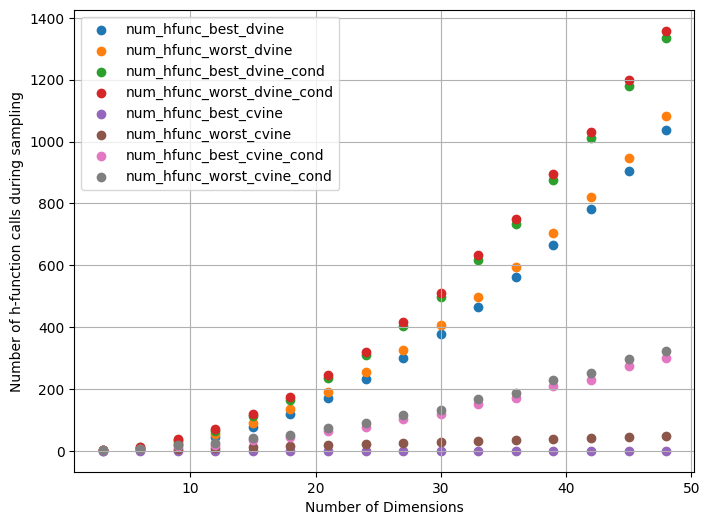

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
df = pd.DataFrame(
    {
        "num_dim": lst_num_dim,
        "num_hfunc_best_dvine": lst_num_hfunc_best_dvine,
        "num_hfunc_worst_dvine": lst_num_hfunc_worst_dvine,
        "num_hfunc_best_dvine_cond": lst_num_hfunc_best_dvine_cond,
        "num_hfunc_worst_dvine_cond": lst_num_hfunc_worst_dvine_cond,
        "num_hfunc_best_cvine": lst_num_hfunc_best_cvine,
        "num_hfunc_worst_cvine": lst_num_hfunc_worst_cvine,
        "num_hfunc_best_cvine_cond": lst_num_hfunc_best_cvine_cond,
        "num_hfunc_worst_cvine_cond": lst_num_hfunc_worst_cvine_cond,
    },
    index=lst_num_dim,
)
for col in df.columns:
    if "dim" in col:
        continue
    ax.scatter(df.index, df[col], label=col)
plt.grid()
# plt.xscale("log")
plt.legend()
plt.xlabel("Number of Dimensions")
plt.ylabel("Number of h-function calls during sampling")